<h3>Research Question:</h3><p></p>
<p>
Tentative  Research Question:
"Based on city-wide income levels in New York City, how do they correlate with the prevalence of violent and non-violent crimes? Using this correlation, can we construct a predictive model, incorporating demographic data (such as race and income) and criminal data (like types of crimes (non-violent vs violent), that can be applied to forecast potential criminal behaviors in other cities?"

<p>

<p> Sub-Questions:
How do city-wide income levels in New York City historically relate to overall crime rates?
Is there a discernible pattern between violent and non-violent crimes in relation to city-wide income disparities?
How do other city-wide demographic factors, especially race, interplay with income in influencing crime rates?
Given the data from New York City, can we develop a predictive model suitable for other cities, and what are the ethical considerations and potential applications of such a model?
<p>

<p style="font-size: 20px"> Imports <p>

In [427]:
import pandas as pd
import duckdb as db
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

<p style="font-size: 24px">Data Cleaning</p>

<p> sources that extend beyond scope of info2950:
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.at.html
<p>

### part 1: cleaning NYC crime data

In [428]:
#clean database on felonies and convert values to int
felonies_nyc= pd.read_csv("felony.csv")
for column in felonies_nyc.columns[1:]:
    if felonies_nyc[column].dtype != int:
        felonies_nyc[column] = felonies_nyc[column].str.replace(",", "").astype(int)


In [429]:
#clean database on non-felonies and convert values to int
nfelonies_nyc= pd.read_csv("non-felony.csv")
for column in nfelonies_nyc.columns[1:]:
    if nfelonies_nyc[column].dtype != int:
        nfelonies_nyc[column] = nfelonies_nyc[column].astype(int)

In [430]:
# Remove the last row from both, which contains individual daTa totals
felonies_nyc = felonies_nyc.iloc[:-1]
nfelonies_nyc = nfelonies_nyc.iloc[:-1]
merged_df = pd.concat([felonies_nyc, nfelonies_nyc], ignore_index=True)


In [431]:
#print crime data
print(merged_df)

                                      OFFENSE   2000   2001   2002   2003  \
0             MURDER & NON-NEGL. MANSLAUGHTER    673    649    587    597   
1                                        RAPE   2068   1981   2144   2070   
2                                     ROBBERY  32562  28202  27229  25989   
3                              FELONY ASSAULT  25924  23453  21147  19139   
4                                    BURGLARY  38352  32763  31275  29110   
5                               GRAND LARCENY  49631  46329  45771  46751   
6              GRAND LARCENY OF MOTOR VEHICLE  35442  29531  26656  23413   
7        FELONY POSSESSION OF STOLEN PROPERTY   2194   2114   1976   1545   
8          FORGERY/THEFT_FRAUD/IDENTITY THEFT   5714   5594   5859   8112   
9                                       ARSON   3189   2681   1902   1492   
10                      FELONY SEX CRIMES (3)   1839   1831   1513   1295   
11                 FELONY DANGEROUS DRUGS (1)  38088  30743  29692  24076   

### part 2: Cleaning NYC demographics data

In [432]:
#get totals starting from second column   
new_totals = merged_df.iloc[:, 1:].sum()

# Set the name for the last row in OFFENSE to Total Crime
merged_df.at[len(merged_df) - 1, 'OFFENSE'] = "Total Crime"

#add new totals to that row 
merged_df.iloc[len(merged_df) - 1, 1:] = new_totals.values 

In [433]:
#print total crime data
print(merged_df)

                                      OFFENSE    2000    2001    2002    2003  \
0             MURDER & NON-NEGL. MANSLAUGHTER     673     649     587     597   
1                                        RAPE    2068    1981    2144    2070   
2                                     ROBBERY   32562   28202   27229   25989   
3                              FELONY ASSAULT   25924   23453   21147   19139   
4                                    BURGLARY   38352   32763   31275   29110   
5                               GRAND LARCENY   49631   46329   45771   46751   
6              GRAND LARCENY OF MOTOR VEHICLE   35442   29531   26656   23413   
7        FELONY POSSESSION OF STOLEN PROPERTY    2194    2114    1976    1545   
8          FORGERY/THEFT_FRAUD/IDENTITY THEFT    5714    5594    5859    8112   
9                                       ARSON    3189    2681    1902    1492   
10                      FELONY SEX CRIMES (3)    1839    1831    1513    1295   
11                 FELONY DA

In [434]:
#reading the NYC demographics csv file
nyc_demographics= pd.read_csv('NYC_demographics.csv', encoding='latin1')

In [435]:
#changing year column values to int type so that they can be read as ints in further cleaning
nyc_demographics['Year']= nyc_demographics['Year'].astype(int)
#renaming column to prevent syntax issues 
nyc_demographics.rename(columns={'Non-Hispanic': 'NonHispanic'}, inplace=True)

In [436]:
#checking and changing column values that are originally objects and removing commas to facilitate float conversion later
for col in nyc_demographics:
    if nyc_demographics[col].dtype == 'object':
        nyc_demographics[col]= nyc_demographics[col].str.replace(",", "")


In [437]:
#changing the column value type from object to float
nyc_demographics[['White', 'NonHispanic', 'Black', 'Asian', 'Mixed',
                   'Hispanic',]]= nyc_demographics[['White', 'NonHispanic',
                    'Black', 'Asian', 'Mixed', 'Hispanic',]].astype(float)


In [438]:
#creating a clean dataframe that only has relevant columns
nyc_demographics_clean= db.sql("""
SELECT Year, White, NonHispanic, Black, Asian, Mixed, Hispanic
FROM nyc_demographics
WHERE Year > 1980""").df()

In [439]:
#confirming that new dataframe has correct information
print(nyc_demographics_clean)

   Year      White  NonHispanic      Black      Asian      Mixed   Hispanic
0  1990  3827088.0    3163125.0  2102512.0   512719.0   880245.0  1783511.0
1  2000  3576385.0    2801267.0  2129762.0   792477.0  1509654.0  2160554.0
2  2010  3597341.0    2722904.0  2088510.0  1043535.0  1445747.0  2336076.0
3  2020  3000945.0    2719856.0  1943645.0  1385144.0  2474456.0  2490350.0


### part 3: Cleaning NYC income Data ###

In [440]:
#Loading csv file
nyc_income= pd.read_csv('income.csv', encoding='latin1')

#making sure each column besides the first column has int values
for column in nyc_income.columns[1:]:
    if nyc_income[column].dtype != int:
        nyc_income[column] = nyc_income[column].astype(int)

In [441]:
print(nyc_income)

  Geographic Area (in dollars)   1990   2000    2010    2013    2014    2015  \
0                        Bronx  15576  19965   29910   30647   31556   32778   
1             Brooklyn (Kings)  18333  25136   35811   39586   41399   43915   
2                    Manhattan  50225  88640  121550  145231  152690  155779   
3                       Queens  22397  28516   37259   39789   40997   43216   
4     Staten Island (Richmond)  23519  34676   43438   46219   48123   50894   
5                New York City  25698  37947   52273   58966   61498   63815   

     2016    2017  
0   33310   35564  
1   45629   48758  
2  164056  175960  
3   44031   46829  
4   51836   54908  
5   66283   70879  


## Exploratory Data Analysis ##

In [442]:
#Summary statistics for income
summary_stats = nyc_income.describe()
print(summary_stats)

               1990          2000           2010           2013  \
count      6.000000      6.000000       6.000000       6.000000   
mean   25958.000000  39146.666667   53373.500000   60073.000000   
std    12437.932947  25092.876660   34253.802012   42760.007086   
min    15576.000000  19965.000000   29910.000000   30647.000000   
25%    19349.000000  25981.000000   36173.000000   39636.750000   
50%    22958.000000  31596.000000   40348.500000   43004.000000   
75%    25153.250000  37129.250000   50064.250000   55779.250000   
max    50225.000000  88640.000000  121550.000000  145231.000000   

                2014           2015           2016           2017  
count       6.000000       6.000000       6.000000       6.000000  
mean    62710.500000   65066.166667   67524.166667   72149.666667  
std     45181.488947   45603.862115   48513.895574   52158.014160  
min     31556.000000   32778.000000   33310.000000   35564.000000  
25%     41097.500000   43390.750000   44430.500000   473

In [443]:
#summary statistics for crime
summary_stats = merged_df.describe()
print(summary_stats)

                2000           2001           2002           2003  \
count      15.000000      15.000000      15.000000      15.000000   
mean    34472.066667   30860.866667   29176.533333   26852.400000   
std     66158.557380   59191.275630   56255.137347   52046.330998   
min       673.000000     649.000000     587.000000     597.000000   
25%      2576.000000    2397.500000    2060.000000    1807.500000   
50%     12934.000000   16026.000000   13291.000000    8400.000000   
75%     36765.000000   30137.000000   28460.500000   25032.500000   
max    265513.000000  237986.000000  225802.000000  208286.000000   

                2004           2005           2006           2007  \
count      15.000000      15.000000      15.000000      15.000000   
mean    27013.200000   26323.866667   25623.800000   24815.666667   
std     52143.531671   50792.126289   49407.240197   48016.672173   
min       570.000000     539.000000     596.000000     496.000000   
25%      1847.000000    1844.5000

In [444]:
#summary_stats for demographics
summary_stats = nyc_demographics_clean.describe()
print(summary_stats)

              Year         White   NonHispanic         Black         Asian  \
count     4.000000  4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00   
mean   2005.000000  3.500440e+06  2.851788e+06  2.066107e+06  9.334688e+05   
std      12.909944  3.518293e+05  2.109504e+05  8.341886e+04  3.710499e+05   
min    1990.000000  3.000945e+06  2.719856e+06  1.943645e+06  5.127190e+05   
25%    1997.500000  3.432525e+06  2.722142e+06  2.052294e+06  7.225375e+05   
50%    2005.000000  3.586863e+06  2.762086e+06  2.095511e+06  9.180060e+05   
75%    2012.500000  3.654778e+06  2.891732e+06  2.109324e+06  1.128937e+06   
max    2020.000000  3.827088e+06  3.163125e+06  2.129762e+06  1.385144e+06   

              Mixed      Hispanic  
count  4.000000e+00  4.000000e+00  
mean   1.577526e+06  2.192623e+06  
std    6.614773e+05  3.042045e+05  
min    8.802450e+05  1.783511e+06  
25%    1.304372e+06  2.066293e+06  
50%    1.477700e+06  2.248315e+06  
75%    1.750854e+06  2.374644e+06  
max    2.

                                      OFFENSE    2000    2001    2002    2003  \
0             MURDER & NON-NEGL. MANSLAUGHTER     673     649     587     597   
1                                        RAPE    2068    1981    2144    2070   
2                                     ROBBERY   32562   28202   27229   25989   
3                              FELONY ASSAULT   25924   23453   21147   19139   
4                                    BURGLARY   38352   32763   31275   29110   
5                               GRAND LARCENY   49631   46329   45771   46751   
6              GRAND LARCENY OF MOTOR VEHICLE   35442   29531   26656   23413   
7        FELONY POSSESSION OF STOLEN PROPERTY    2194    2114    1976    1545   
8          FORGERY/THEFT_FRAUD/IDENTITY THEFT    5714    5594    5859    8112   
9                                       ARSON    3189    2681    1902    1492   
10                      FELONY SEX CRIMES (3)    1839    1831    1513    1295   
11                 FELONY DA

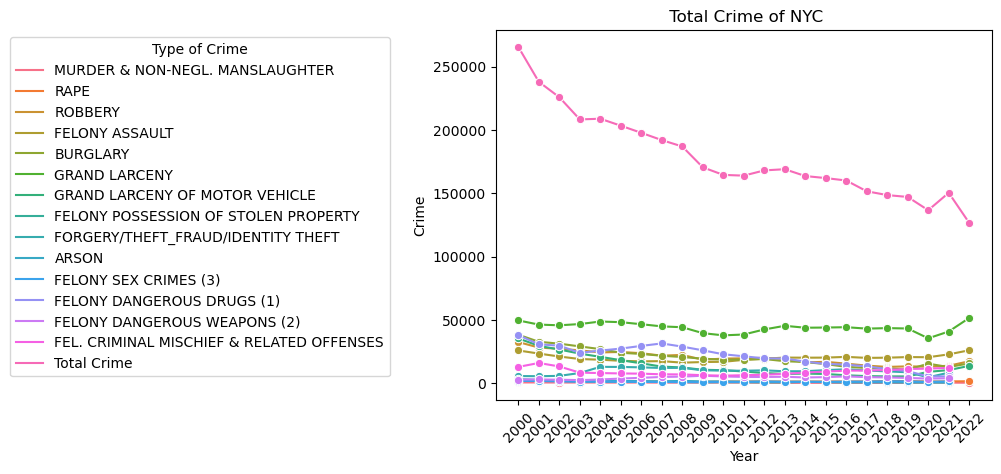

In [445]:
#VISUALIZING TOTAL CRIME AS A LINEPLOT
nyc_crime= merged_df

print(merged_df)
#Melting the DataFrame
melted_demographic = nyc_crime.melt(id_vars=['OFFENSE'], var_name='Year', value_name='Count')

#visualizong with a line plot
sns.lineplot(data=melted_demographic, x='Year', y='Count', hue='OFFENSE', marker='o')
plt.title(" Total Crime of NYC")
plt.xlabel("Year")
plt.ylabel("Crime")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Adjust the legend to be outside the plot area
plt.legend(title="Type of Crime", bbox_to_anchor=(-0.20, 1), loc='upper right')




In [446]:
print(merged_df)

                                      OFFENSE    2000    2001    2002    2003  \
0             MURDER & NON-NEGL. MANSLAUGHTER     673     649     587     597   
1                                        RAPE    2068    1981    2144    2070   
2                                     ROBBERY   32562   28202   27229   25989   
3                              FELONY ASSAULT   25924   23453   21147   19139   
4                                    BURGLARY   38352   32763   31275   29110   
5                               GRAND LARCENY   49631   46329   45771   46751   
6              GRAND LARCENY OF MOTOR VEHICLE   35442   29531   26656   23413   
7        FELONY POSSESSION OF STOLEN PROPERTY    2194    2114    1976    1545   
8          FORGERY/THEFT_FRAUD/IDENTITY THEFT    5714    5594    5859    8112   
9                                       ARSON    3189    2681    1902    1492   
10                      FELONY SEX CRIMES (3)    1839    1831    1513    1295   
11                 FELONY DA

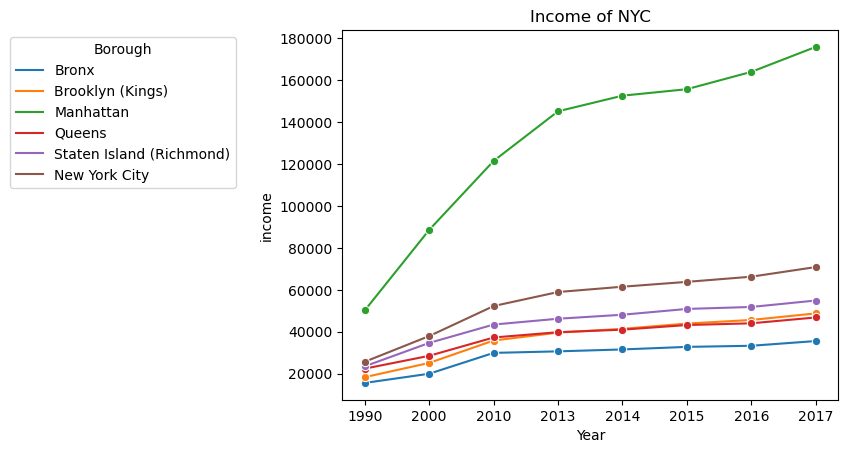

In [447]:
#VISUALIZING INCOME AS A LINE GRAPH

#Melting the DataFrame
melted_demographic = nyc_income.melt(id_vars=['Geographic Area (in dollars)'], var_name='Year', value_name='Count')

#visualizong with a line plot
sns.lineplot(data=melted_demographic, x='Year', y='Count', hue='Geographic Area (in dollars)', marker='o')
plt.title("Income of NYC")
plt.xlabel("Year")
plt.ylabel("income")
plt.legend(title="Borough",bbox_to_anchor=(-0.20, 1), loc='upper right')

  Geographic Area (in dollars)  Year  Count
0                        Bronx  1990  15576
1             Brooklyn (Kings)  1990  18333
2                    Manhattan  1990  50225
3                       Queens  1990  22397
4     Staten Island (Richmond)  1990  23519


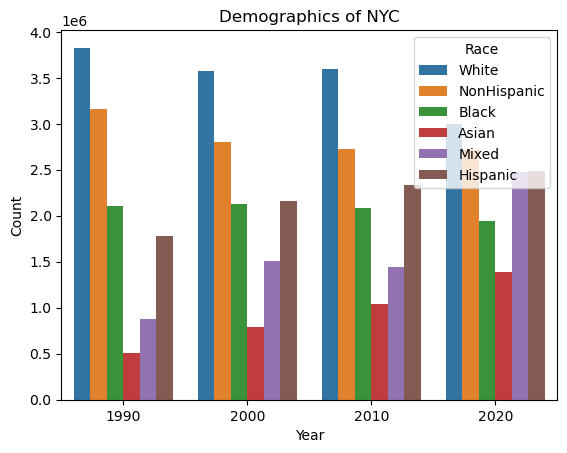

In [448]:
#melting the Demographic dataframe and adding a column titled "Race" so that I can make a barplot that is colored by race
melted_nyc_demographic= pd.melt(nyc_demographics_clean, id_vars= 'Year', var_name= 'Race', value_name='Count')
print(melted_demographic.head())

#visualizing data with a barplot
sns.barplot(data= melted_nyc_demographic, x= 'Year', y='Count', hue='Race')
plt.title("Demographics of NYC")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Race", loc='upper right');

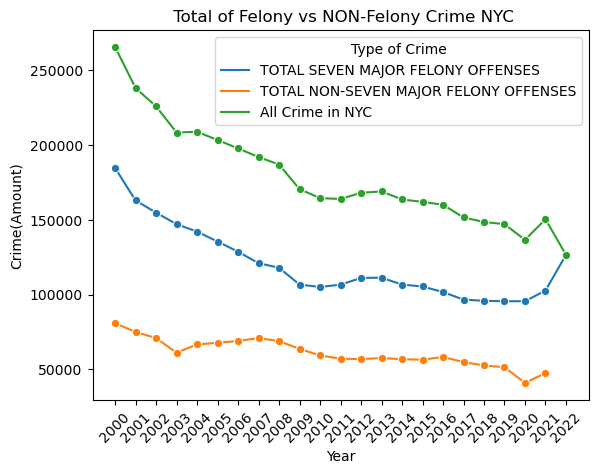

In [449]:
#VISUALIZING TOTAL CRIME WITH VIOLENT AND N0N VIOLENT CRIME

# Clean database on felonies and convert values to int
felonies_nyc = pd.read_csv("felony.csv")
for column in felonies_nyc.columns[1:]:
    if felonies_nyc[column].dtype != int:
        felonies_nyc[column] = felonies_nyc[column].str.replace(",", "").astype(int)

# Clean database on non-felonies and convert values to int
nfelonies_nyc = pd.read_csv("non-felony.csv")
for column in nfelonies_nyc.columns[1:]:
    if nfelonies_nyc[column].dtype != int:
        nfelonies_nyc[column] = nfelonies_nyc[column].astype(int)


#changing the label for Crime
merged_df['OFFENSE'] = "All Crime in NYC"

# Extract the totals for felonies and non-felonies
total_nyc_crime = merged_df.iloc[-1:]
total_felonies = felonies_nyc.iloc[-1:]
total_non_felonies = nfelonies_nyc.iloc[-1:]

# Combine the totals into a single DataFrame
combined_totals = pd.concat([total_felonies, total_non_felonies, total_nyc_crime], ignore_index=True)

# Melt the combined totals DataFrame
melted_totals = combined_totals.melt(id_vars=['OFFENSE'], var_name='Year', value_name='Count')

#visualizong with a line plot
sns.lineplot(data=melted_totals, x='Year', y='Count', hue='OFFENSE', marker='o')
plt.title(" Total of Felony vs NON-Felony Crime NYC")
plt.xlabel("Year")
plt.ylabel("Crime(Amount)")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Adjust the legend to be outside the plot area
plt.legend(title="Type of Crime", loc='upper right')



                Income  Total Crimes
Income        1.000000     -0.243272
Total Crimes -0.243272      1.000000


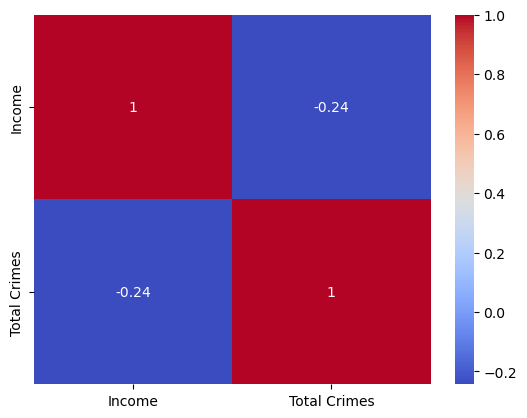

In [450]:
#correlation matrix between household income and crime

# Load the datasets
crime_data = merged_df
household_income = melted_demographic

#restructuring crime data set so it can match the year and total structure of income data set
restructured_crime = {
    'OFFENSE': ['Total Crime OF NYC'] * 15,
    '2000': [673, 2068, 32562, 25924, 38352, 49631, 35442, 2194, 5714, 3189, 1839, 38088, 2958, 12934, 265513],
    '2001': [649, 1981, 28202, 23453, 32763, 46329, 29531, 2114, 5594, 2681, 1831, 30743, 3030, 16026, 237986],
    '2002': [587, 2144, 27229, 21147, 31275, 45771, 26656, 1976, 5859, 1902, 1513, 29692, 2804, 13291, 225802],
    '2003': [597, 2070, 25989, 19139, 29110, 46751, 23413, 1545, 8112, 1492, 1295, 24076, 2511, 8400, 208286],
    '2004': [570, 1905, 24373, 18622, 26976, 48763, 20884, 1358, 12984, 1789, 1263, 25824, 2987, 8074, 208826],
    '2005': [539, 1858, 24722, 17750, 24117, 48243, 18246, 1250, 12896, 1831, 1162, 27391, 3748, 7776, 203329],
    '2006': [596, 1525, 23739, 17309, 23143, 46625, 15745, 1175, 12579, 1679, 1096, 29516, 4315, 7605, 197710],
    '2007': [496, 1351, 21809, 17493, 21762, 44924, 13174, 1073, 12075, 1527, 1031, 31459, 5004, 7090, 191967],
    '2008': [523, 1299, 22401, 16284, 20725, 44242, 12482, 1016, 12216, 1896, 909, 28936, 5263, 7003, 186914],
    '2009': [523, 1299, 22401, 16284, 20725, 44242, 12482, 1016, 12216, 1896, 909, 28936, 5263, 7003, 186914],
    '2010': [596, 1525, 23739, 17309, 23143, 46625, 15745, 1175, 12579, 1679, 1096, 29516, 4315, 7605, 197710],
    '2011': [496, 1351, 21809, 17493, 21762, 44924, 13174, 1073, 12075, 1527, 1031, 31459, 5004, 7090, 191967],
    '2012': [335, 1378, 19128, 20297, 17429, 45368, 7400, 689, 9493, 1187, 1073, 19571, 5155, 7468, 168985],
    '2013': [335, 1378, 19128, 20297, 17429, 45368, 7400, 689, 9493, 1187, 1073, 19571, 5155, 7468, 168985],
    '2014': [333, 1352, 16539, 20207, 16765, 43862, 7664, 1090, 9520, 1205, 1135, 17113, 4605, 8466, 163591],
    '2015': [352, 1438, 16931, 20270, 15125, 44005, 7332, 904, 10400, 1026, 1152, 15279, 4848, 9253, 161973],
    '2016': [335, 1438, 15500, 20847, 12990, 44279, 6327, 769, 11079, 802, 1336, 14712, 5465, 9966, 160062],
    '2017': [292, 1449, 13956, 20052, 12083, 43150, 5676, 1019, 10063, 680, 1367, 13348, 4843, 10073, 151565],
    '2018': [295, 1794, 12913, 20208, 11687, 43558, 5428, 951, 9413, 741, 1615, 11236, 4639, 10427, 148550],
    '2019': [319, 1755, 13371, 20698, 10783, 43250, 5430, 733, 8684, 711, 1562, 9587, 4219, 11302, 147090],
    '2020': [468, 1427, 13106, 20572, 15478, 35505, 9037, 699, 4746, 832, 1143, 5372, 3677, 11569, 136608],
    '2021': [488, 1491, 13831, 22835, 12811, 40870, 10415, 712, 8389, 632, 1503, 5485, 3990, 12179, 150376],

}

# Convert the dictionary to a DataFrame
crime_df = pd.DataFrame(restructured_crime)

# Compute the total crimes for each year
total_crimes_per_year = crime_df.sum(axis=0).drop('OFFENSE')

# Convert the Series to a DataFrame for merging
total_crimes_df = total_crimes_per_year.reset_index()
total_crimes_df.columns = ['Year', 'Total Crimes']

# Merge the datasets
merged_data = pd.merge(household_income, total_crimes_df, on='Year', how='left')
#renaming count as income
merged_data = merged_data.rename(columns={"Count": "Income"})


#calculating correlation matrix
correlation_matrix = merged_data[['Income', 'Total Crimes']].corr()


print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

<p style="font-size: 20px;">Data Limitations</p>

<p>Some limitations we may approach when dealing with our data is the lack of dates (in years) for each dataset. For instance, we have crime data that spans from the year 2000 to 2020 and there are datapoints for every  year in between, meanwhile for demographic data we have usable data from the year 1990 to 2020, however there are only data points for each decade between that range. These limitations should not grossly affect any conclusions that we may come to make, but can possibly affect the intensity of our findings and the fit of our logistic regression model that we plan to produce in the future.</p>